In [ ]:
import pandas as pd
import numpy as np
import re
import nltk
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
import re
import matplotlib.pyplot as plt
import seaborn as sns


__**Note**__: 

1.  We've chosen to work with Tensorflow 2 which comes up with a tight integration of Keras. the code will remain for the most part the same

2. Due to the large size of The IMDB_csv file  (63Mo) we couldn't upload it to my drive to work with so we downloaded one from the cloud using datasets package.

# Getting the data

Dataset Description

- The IMDb dataset is a binary sentiment analysis dataset consisting of 50,000 reviews from the Internet Movie Database (IMDb) labeled as positive or negative (this is the polarity). The dataset contains of an even number of positive and negative reviews (balanced). Only highly polarizing reviews are considered. A negative review has a score ≤ 4 out of 10, and a positive review has a score ≥ 7 out of 10. No more than 30 reviews are included per movie. There are 25,000 highly polar movie reviews for training, and 25,000 for testing.

In [ ]:
!pip install -q datasets

In [ ]:
from datasets import load_dataset

dataset_train = load_dataset('imdb',split='train')
train_df=pd.DataFrame(dataset_train)

dataset_test = load_dataset('imdb',split='test')
test_df=pd.DataFrame(dataset_test)

Reusing dataset imdb (/root/.cache/huggingface/datasets/imdb/plain_text/1.0.0/2fdd8b9bcadd6e7055e742a706876ba43f19faee861df134affd7a3f60fc38a1)
Reusing dataset imdb (/root/.cache/huggingface/datasets/imdb/plain_text/1.0.0/2fdd8b9bcadd6e7055e742a706876ba43f19faee861df134affd7a3f60fc38a1)


In [ ]:
train_df.head()

,text,label
0,I rented I AM CURIOUS-YELLOW from my video sto...,0
1,"""I Am Curious: Yellow"" is a risible and preten...",0
2,If only to avoid making this type of film in t...,0
3,This film was probably inspired by Godard's Ma...,0
4,"Oh, brother...after hearing about this ridicul...",0


In [ ]:
train_df.shape,test_df.shape

((25000, 2), (25000, 2))

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


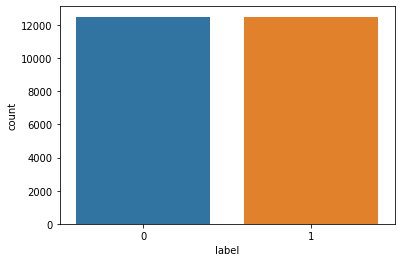

In [ ]:
sns.countplot(train_df.label)

In [ ]:
print(train_df.text[3])

This film was probably inspired by Godard's Masculin, féminin and I urge you to see that film instead.<br /><br />The film has two strong elements and those are, (1) the realistic acting (2) the impressive, undeservedly good, photo. Apart from that, what strikes me most is the endless stream of silliness. Lena Nyman has to be most annoying actress in the world. She acts so stupid and with all the nudity in this film,...it's unattractive. Comparing to Godard's film, intellectuality has been replaced with stupidity. Without going too far on this subject, I would say that follows from the difference in ideals between the French and the Swedish society.<br /><br />A movie of its time, and place. 2/10.


# Preprocessing

In [ ]:
TAG_RE = re.compile(r'<[^>]+>')
def remove_tags(text):
  return TAG_RE.sub('', text)

def preprocess_text(sen):
# Removing html tags
  sentence = remove_tags(sen)
# Remove punctuations and numbers
  sentence = re.sub('[^a-zA-Z]', ' ', sentence)
# Single character removal
  sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)
# Removing multiple spaces
  sentence = re.sub(r'\s+', ' ', sentence)
  return sentence



In [ ]:
# removing stopwords
nltk.download('stopwords')
from nltk.corpus import stopwords
print(stopwords.words('english'))
print(len(stopwords.words('english')))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'ea

To increase efficiency we can use lemmatization (see image below) all the while maintaining meaning
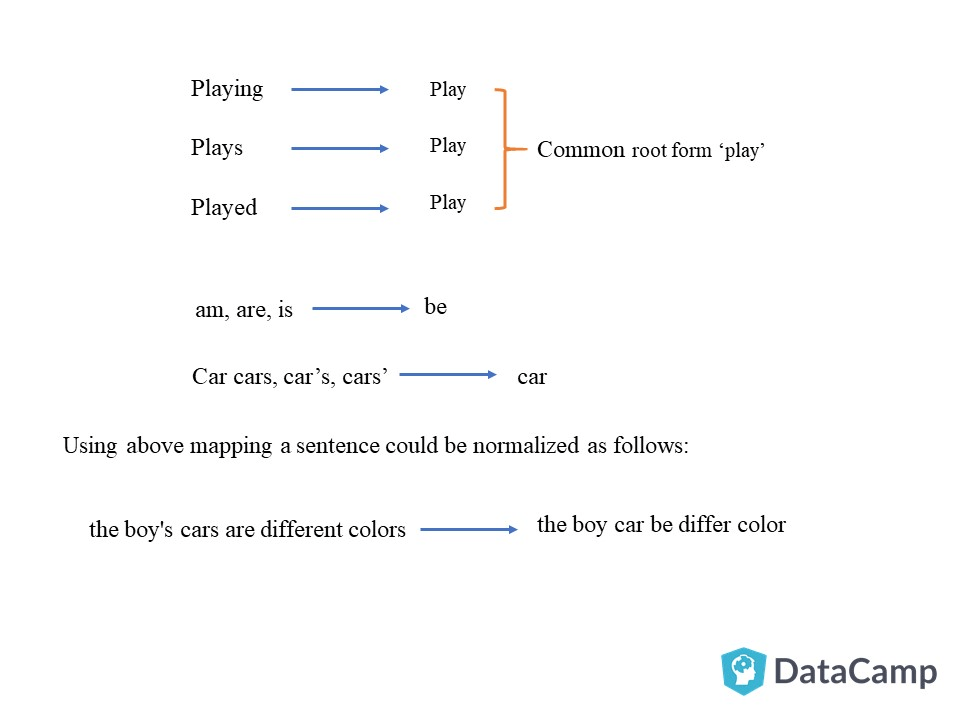

In [ ]:
from nltk.stem import WordNetLemmatizer
nltk.download('punkt')
nltk.download('wordnet')
english_stop_words=stopwords.words('english')
lemmatizer=WordNetLemmatizer()
def remove_stop_words(text):
    clean_reviews = []
    for review in text:
      clean_reviews.append( ' '.join([lemmatizer.lemmatize(word.lower()) for word in review.split() if word not in english_stop_words]))
    return clean_reviews



[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [ ]:
# Apply the transformations on the Text column for both train and test df
train_df.text=train_df.text.map(preprocess_text)
test_df.text=test_df.text.map(preprocess_text)


In [ ]:
train_df.text=remove_stop_words(train_df.text)
test_df.text=remove_stop_words(test_df.text)

In [ ]:
train_df.text[3]

'this film probably inspired godard masculin minin urge see film instead the film two strong element realistic acting impressive undeservedly good photo apart strike endless stream silliness lena nyman annoying actress world she act stupid nudity film unattractive comparing godard film intellectuality replaced stupidity without going far subject would say follows difference ideal french swedish society movie time place'

we can see that all stopwords have been removed and the stemming was succefully applied

In [ ]:
train_df.text[:5]

0    i rented am curious yellow video store controv...
1    am curious yellow risible pretentious steaming...
2    if avoid making type film future this film int...
3    this film probably inspired godard masculin mi...
4    oh brother hearing ridiculous film umpteen yea...
Name: text, dtype: object

- *the preprocessing was applied successfully as all redundant spaces,tags, numbers and single characters were removed from each review*

- The encoding of labels has already been done when we downloaded the dataset

- The dataset has already been divided into a train and a test set however to respect the proportions given in the TP (80/20 split) I will concatenate  both train_df and test_df and the do the train_test_split accordingly

# Creating the dataset

In [ ]:
data=pd.concat([train_df,test_df])
data.head()

,text,label
0,i rented am curious yellow video store controv...,0
1,am curious yellow risible pretentious steaming...,0
2,if avoid making type film future this film int...,0
3,this film probably inspired godard masculin mi...,0
4,oh brother hearing ridiculous film umpteen yea...,0


In [ ]:
data.shape

(50000, 2)

In [ ]:
X=data.text.tolist()
y=data.label.to_numpy()

In [ ]:
len(X),y.shape

(50000, (50000,))

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [ ]:
len(X_train),y_train.shape,len(X_test),y_test.shape

(40000, (40000,), 10000, (10000,))

# Embedding Layer

In [ ]:
from keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer(num_words=5000) 
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [ ]:
from keras.preprocessing.sequence import pad_sequences
# Adding 1 because of reserved 0 index 
vocab_size = len(tokenizer.word_index) + 1 
maxlen = 100 
X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

In [ ]:
# Let's see the tokenization and padding on the first review
print(len(X_train[0]))

100


# Using GloVe word embeddings

1. *Download the Zip file*

In [ ]:
!wget http://nlp.stanford.edu/data/glove.6B.zip

--2022-05-02 10:04:33--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2022-05-02 10:04:33--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2022-05-02 10:04:33--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6

2. *Unzip it*

In [ ]:
!unzip glove*.zip

Archive:  glove.6B.zip
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
  inflating: glove.6B.200d.txt       
  inflating: glove.6B.300d.txt       


In [ ]:
embeddings_dictionary = dict() 
glove_file = open("glove.6B.100d.txt", encoding="utf8") 
for line in glove_file: 
  records = line.split() 
  word = records[0] 
  vector_dimensions = np.asarray(records[1:],dtype='float32') 
  embeddings_dictionary [word] = vector_dimensions 
glove_file.close()

In [ ]:
print('Found %s word vectors.' % len(embeddings_dictionary))

Found 400000 word vectors.


In [ ]:
embedding_matrix = np.zeros((vocab_size, 100)) 
for word, index in tokenizer.word_index.items(): 
  embedding_vector = embeddings_dictionary.get(word) 
  if embedding_vector is not None: 
    embedding_matrix[index] = embedding_vector


In [ ]:
embedding_matrix.shape

(83525, 100)

# Classification using a simple neural network

In [ ]:
def simple_model(embedding_matrix,dims=100):
  model=keras.Sequential([keras.layers.Embedding(vocab_size, dims, weights=[embedding_matrix], input_length=maxlen , trainable=False),
                                    keras.layers.Flatten(),
                                    keras.layers.Dense(1,activation='sigmoid')])

  model.compile(loss='binary_crossentropy',optimizer="adam",metrics=['accuracy'])
  return model

In [ ]:
simple=simple_model()
simple.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 100)          8352500   
                                                                 
 flatten (Flatten)           (None, 10000)             0         
                                                                 
 dense (Dense)               (None, 1)                 10001     
                                                                 
Total params: 8,362,501
Trainable params: 10,001
Non-trainable params: 8,352,500
_________________________________________________________________


In [ ]:
NUM_EPOCHS = 6
history = simple.fit(X_train,y_train, epochs=NUM_EPOCHS, batch_size=128,validation_split=0.2,verbose=1)

Epoch 1/6
250/250 [==============================] - 4s 4ms/step - loss: 0.5700 - accuracy: 0.7023 - val_loss: 0.5086 - val_accuracy: 0.7542
Epoch 2/6
250/250 [==============================] - 1s 3ms/step - loss: 0.4661 - accuracy: 0.7850 - val_loss: 0.4973 - val_accuracy: 0.7639
Epoch 3/6
250/250 [==============================] - 1s 4ms/step - loss: 0.4263 - accuracy: 0.8091 - val_loss: 0.5199 - val_accuracy: 0.7558
Epoch 4/6
250/250 [==============================] - 1s 4ms/step - loss: 0.4024 - accuracy: 0.8202 - val_loss: 0.4988 - val_accuracy: 0.7632
Epoch 5/6
250/250 [==============================] - 1s 3ms/step - loss: 0.3898 - accuracy: 0.8262 - val_loss: 0.5227 - val_accuracy: 0.7542
Epoch 6/6
250/250 [==============================] - 1s 3ms/step - loss: 0.3745 - accuracy: 0.8348 - val_loss: 0.5172 - val_accuracy: 0.7596


In [ ]:
score = simple.evaluate(X_test, y_test, verbose=1) 
print("Test Score:", score[0]) 
print("Test Accuracy:", score[1])

313/313 [==============================] - 2s 5ms/step - loss: 0.5272 - accuracy: 0.7576
Test Score: 0.527189314365387
Test Accuracy: 0.7576000094413757


In [ ]:
import matplotlib.pyplot as plt


def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

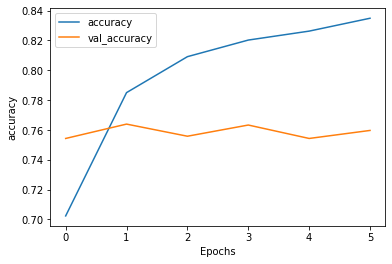

In [ ]:
plot_graphs(history, 'accuracy')

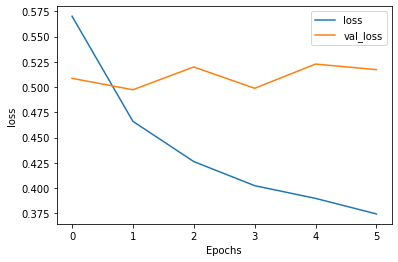

In [ ]:
plot_graphs(history, 'loss')

- There's clear overfitting in fact:
the training accuracy is significantly higher then validation accuracy and the val_loss > loss

# Classification with CONV1D

In [ ]:
def conv_model(embedding_matrix,dims=100):
  model = keras.Sequential([
      keras.layers.Embedding(vocab_size, dims, weights=[embedding_matrix], input_length=maxlen,trainable=False),
      keras.layers.Conv1D(128, 5, activation='relu'),
      keras.layers.MaxPooling1D(),
      keras.layers.Flatten(),
      keras.layers.Dense(1, activation='sigmoid')

  ])
  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
  return model

In [ ]:
conv=conv_model()
conv.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 100, 100)          8352500   
                                                                 
 conv1d (Conv1D)             (None, 96, 128)           64128     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 48, 128)          0         
 )                                                               
                                                                 
 flatten_1 (Flatten)         (None, 6144)              0         
                                                                 
 dense_1 (Dense)             (None, 1)                 6145      
                                                                 
Total params: 8,422,773
Trainable params: 70,273
Non-trainable params: 8,352,500
_______________________________________

In [ ]:
NUM_EPOCHS = 6
history = conv.fit(X_train,y_train, epochs=NUM_EPOCHS, batch_size=128,validation_split=0.2,verbose=1)

Epoch 1/6
250/250 [==============================] - 13s 17ms/step - loss: 0.5285 - accuracy: 0.7318 - val_loss: 0.4269 - val_accuracy: 0.8058
Epoch 2/6
250/250 [==============================] - 3s 12ms/step - loss: 0.3922 - accuracy: 0.8243 - val_loss: 0.4459 - val_accuracy: 0.7962
Epoch 3/6
250/250 [==============================] - 3s 11ms/step - loss: 0.3243 - accuracy: 0.8632 - val_loss: 0.3748 - val_accuracy: 0.8411
Epoch 4/6
250/250 [==============================] - 3s 11ms/step - loss: 0.2714 - accuracy: 0.8929 - val_loss: 0.4143 - val_accuracy: 0.8167
Epoch 5/6
250/250 [==============================] - 2s 9ms/step - loss: 0.2103 - accuracy: 0.9232 - val_loss: 0.3984 - val_accuracy: 0.8342
Epoch 6/6
250/250 [==============================] - 3s 10ms/step - loss: 0.1557 - accuracy: 0.9522 - val_loss: 0.4214 - val_accuracy: 0.8295


In [ ]:
score = conv.evaluate(X_test, y_test, verbose=1) 
print("Test Score:", score[0]) 
print("Test Accuracy:", score[1])

313/313 [==============================] - 1s 4ms/step - loss: 0.4285 - accuracy: 0.8215
Test Score: 0.4285014271736145
Test Accuracy: 0.8215000033378601


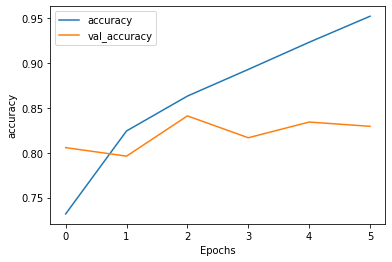

In [ ]:
plot_graphs(history, 'accuracy')

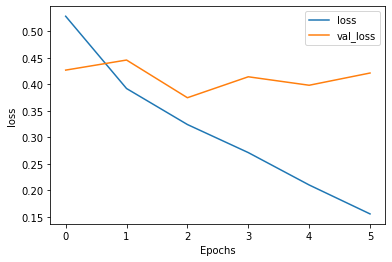

In [ ]:
plot_graphs(history, 'loss')

# Classfication with RNN-LSTM

In [ ]:
def lstm_model(embedding_matrix,dims=100):
  model = keras.Sequential([
        keras.layers.Embedding(vocab_size, dims, weights=[embedding_matrix],input_length=maxlen),
        keras.layers.LSTM(128),
        keras.layers.Flatten(),
        keras.layers.Dense(1, activation='sigmoid')
  ])
  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
  return model

In [ ]:
lstm=lstm_model()
lstm.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 100, 100)          8352500   
                                                                 
 lstm (LSTM)                 (None, 128)               117248    
                                                                 
 flatten_2 (Flatten)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 1)                 129       
                                                                 
Total params: 8,469,877
Trainable params: 8,469,877
Non-trainable params: 0
_________________________________________________________________


In [ ]:
NUM_EPOCHS = 6
history = lstm.fit(X_train,y_train, epochs=NUM_EPOCHS, batch_size=128,validation_split=0.2,verbose=1)

Epoch 1/6
250/250 [==============================] - 15s 40ms/step - loss: 0.4647 - accuracy: 0.7749 - val_loss: 0.3318 - val_accuracy: 0.8575
Epoch 2/6
250/250 [==============================] - 9s 35ms/step - loss: 0.3013 - accuracy: 0.8773 - val_loss: 0.3377 - val_accuracy: 0.8662
Epoch 3/6
250/250 [==============================] - 9s 35ms/step - loss: 0.2586 - accuracy: 0.8967 - val_loss: 0.3147 - val_accuracy: 0.8712
Epoch 4/6
250/250 [==============================] - 9s 36ms/step - loss: 0.2348 - accuracy: 0.9086 - val_loss: 0.2927 - val_accuracy: 0.8767
Epoch 5/6
250/250 [==============================] - 9s 36ms/step - loss: 0.2067 - accuracy: 0.9213 - val_loss: 0.2899 - val_accuracy: 0.8769
Epoch 6/6
250/250 [==============================] - 9s 36ms/step - loss: 0.1910 - accuracy: 0.9282 - val_loss: 0.3303 - val_accuracy: 0.8811


In [ ]:
score = lstm.evaluate(X_test, y_test, verbose=1) 
print("Test Score:", score[0]) 
print("Test Accuracy:", score[1])

313/313 [==============================] - 3s 11ms/step - loss: 0.3470 - accuracy: 0.8763
Test Score: 0.34703123569488525
Test Accuracy: 0.8762999773025513


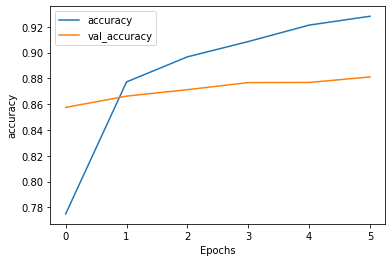

In [ ]:
plot_graphs(history, 'accuracy')

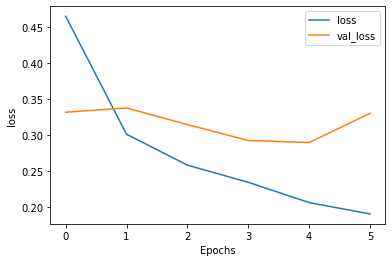

In [ ]:
plot_graphs(history, 'loss')

# Classfication with GRU

In [ ]:
def gru_model(embedding_matrix,dims=100):
  model = keras.Sequential([
      keras.layers.Embedding(vocab_size, dims, weights=[embedding_matrix],input_length=maxlen),
      keras.layers.GRU(128),
      keras.layers.Flatten(),
      keras.layers.Dense(1, activation='sigmoid')
  ])
  
  
  model.compile(loss='binary_crossentropy',optimizer="adam",metrics=['accuracy'])
  return model

In [ ]:
gru=gru_model()
gru.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 100, 100)          8352500   
                                                                 
 gru (GRU)                   (None, 128)               88320     
                                                                 
 flatten_3 (Flatten)         (None, 128)               0         
                                                                 
 dense_3 (Dense)             (None, 1)                 129       
                                                                 
Total params: 8,440,949
Trainable params: 8,440,949
Non-trainable params: 0
_________________________________________________________________


In [ ]:
NUM_EPOCHS = 6
history = gru.fit(X_train,y_train, epochs=NUM_EPOCHS, batch_size=128,validation_split=0.2,verbose=1)

Epoch 1/6
250/250 [==============================] - 12s 36ms/step - loss: 0.5508 - accuracy: 0.6865 - val_loss: 0.3316 - val_accuracy: 0.8616
Epoch 2/6
250/250 [==============================] - 8s 33ms/step - loss: 0.2918 - accuracy: 0.8794 - val_loss: 0.2935 - val_accuracy: 0.8806
Epoch 3/6
250/250 [==============================] - 8s 33ms/step - loss: 0.2395 - accuracy: 0.9064 - val_loss: 0.2834 - val_accuracy: 0.8806
Epoch 4/6
250/250 [==============================] - 8s 33ms/step - loss: 0.2100 - accuracy: 0.9214 - val_loss: 0.2911 - val_accuracy: 0.8815
Epoch 5/6
250/250 [==============================] - 8s 33ms/step - loss: 0.1800 - accuracy: 0.9340 - val_loss: 0.2991 - val_accuracy: 0.8783
Epoch 6/6
250/250 [==============================] - 8s 33ms/step - loss: 0.1549 - accuracy: 0.9457 - val_loss: 0.3369 - val_accuracy: 0.8783


In [ ]:
score = gru.evaluate(X_test, y_test, verbose=1) 
print("Test Score:", score[0]) 
print("Test Accuracy:", score[1])

313/313 [==============================] - 4s 12ms/step - loss: 0.3455 - accuracy: 0.8756
Test Score: 0.34552597999572754
Test Accuracy: 0.8755999803543091


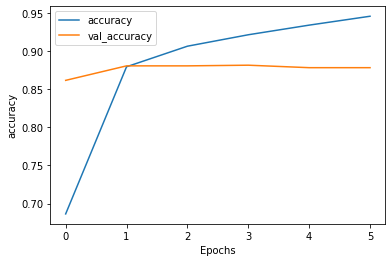

In [ ]:
plot_graphs(history, 'accuracy')

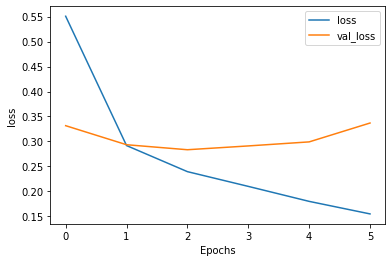

In [ ]:
plot_graphs(history, 'loss')

# Evaluating the 4 models

In [ ]:
from sklearn.metrics import  confusion_matrix, classification_report
def evaluation(model):
  predictions=model.predict(X_test)
  i=0
  for val in predictions:
    if (val<0.5):
      predictions[i]=0
    else:
      predictions[i]=1
    i+=1
  print(predictions.shape)
    
  plt.figure(figsize=(6,6))
  sns.heatmap(confusion_matrix(y_test, predictions),annot=True,fmt='d',cmap='Blues')
  print(classification_report(y_test, predictions))

(10000, 1)
              precision    recall  f1-score   support

           0       0.77      0.74      0.75      5055
           1       0.74      0.78      0.76      4945

    accuracy                           0.76     10000
   macro avg       0.76      0.76      0.76     10000
weighted avg       0.76      0.76      0.76     10000



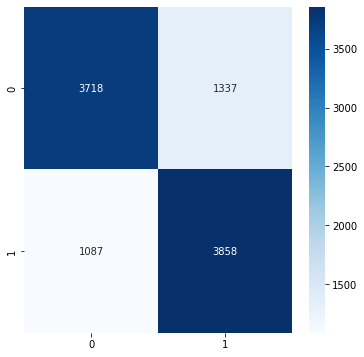

In [ ]:
evaluation(simple)

(10000, 1)
              precision    recall  f1-score   support

           0       0.85      0.78      0.82      5055
           1       0.80      0.86      0.83      4945

    accuracy                           0.82     10000
   macro avg       0.82      0.82      0.82     10000
weighted avg       0.82      0.82      0.82     10000



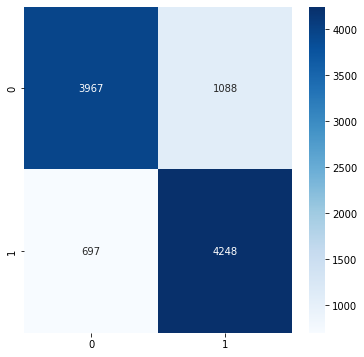

In [ ]:
evaluation(conv)

(10000, 1)
              precision    recall  f1-score   support

           0       0.87      0.89      0.88      5055
           1       0.89      0.86      0.87      4945

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000



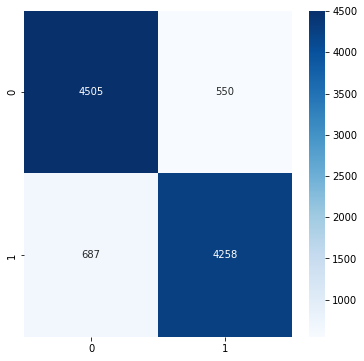

In [ ]:
evaluation(lstm)

(10000, 1)
              precision    recall  f1-score   support

           0       0.87      0.88      0.88      5055
           1       0.88      0.87      0.87      4945

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000



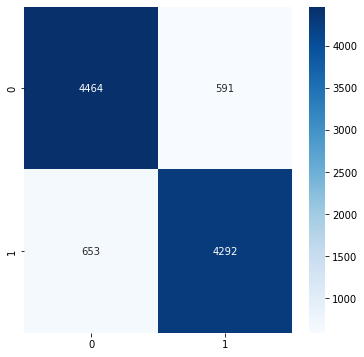

In [ ]:
evaluation(gru)

# Classifying a random review

In [ ]:
import random
num=random.randint(0,len(X_test))
random.seed(42)
random_review=[test_df.text[num]]
print(random_review)
random_review = tokenizer.texts_to_sequences(random_review)

random_review = pad_sequences(random_review, padding='post', maxlen=100)
random_review.shape


# random_review.shape


['i watched film kid thought terrible now older found terrible universal could done better they merely decided make money could using monster to cheap shot these character capable holding movie choice actor deplorable dracula needed bela lugosi frankenstein monster needed karloff in mind disney squalid sequel sequence done decade ago appreciated umiversal started something great original thought could pander mass schlock extremely evident film']


(1, 100)

### using simpel model

In [ ]:
sentiment=""
pred=simple.predict(random_review)
if (pred<0.5):
  pred=0
  sentiment='negative'
else:
  pred=1
  sentiment='positive'
print(pred,sentiment)

0 negative


## using conv model

In [ ]:
sentiment=""
pred=conv.predict(random_review)
if (pred<0.5):
  pred=0
  sentiment='negative'
else:
  pred=1
  sentiment='positive'
print(pred,sentiment)

0 negative


### using lstm model

In [ ]:
sentiment=""
pred=lstm.predict(random_review)
if (pred<0.5):
  pred=0
  sentiment='negative'
else:
  pred=1
  sentiment='positive'
print(pred,sentiment)


0 negative


In [ ]:
sentiment=""
pred=gru.predict(random_review)
if (pred<0.5):
  pred=0
  sentiment='negative'
else:
  pred=1
  sentiment='positive'
print(pred,sentiment)

0 negative


# Comparing different types of Embeddings

# Using GloVe Word Embedding 

Already Done
1. lstm 0.88
1. gru 0.88
2. conv 0.82
3. simple 0.76

# Word2Vec

Word2vec is one of the most popular technique to learn word embeddings using a two-layer neural network. Its input is a text corpus and its output is a set of vectors. Word embedding via word2vec can make natural language computer-readable, then further implementation of mathematical operations on words can be used to detect their similarities. A well-trained set of word vectors will place similar words close to each other in that space. For instance, the words women, men, and human might cluster in one corner, while yellow, red and blue cluster together in another.

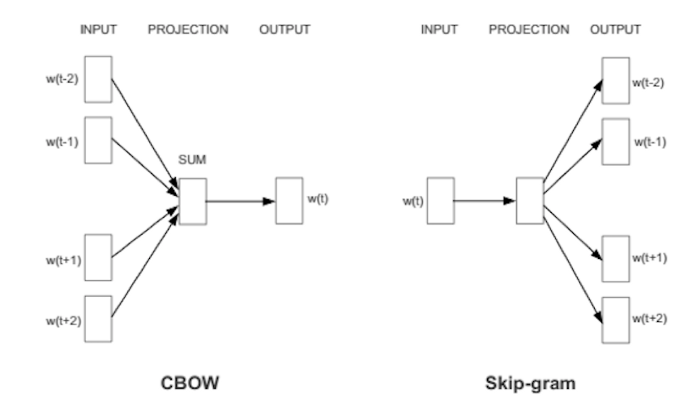


- for our case we're going to implement the **CBOW** version

In [ ]:
import gensim
# import nltk
# nltk.download('punkt')
review_lines = [nltk.word_tokenize(review) for review in nltk.sent_tokenize(str(X))]


size = 100  # The number of dimensions of the embeddings and the default is 100
min_count = 1  # the minimum count of words to consider when training the model
workers = 4     # The number of partitions during training and the default workers is 3
window = 10         # The maximum distance between a target word and words around the target word. The default window is 5
# downsampling = 1e-3 # (0.001) Downsample setting for frequent words
sg=0                # The training algorithm, either CBOW(0) or skip gram(1)

# Initializing the train model
from gensim.models import word2vec
print("Training model....")
model = word2vec.Word2Vec(review_lines,
                          workers=workers,
                          size=size,
                          min_count=min_count,
                          window=window,
                          sg=sg)

print('Completed')
# # To make the model memory efficient
model.init_sims(replace=True)

#vocab size
words=list(model.wv.vocab)
print('Vocabulary size: %d'%len(words))

Training model....
Completed
Vocabulary size: 96197


- saving the model

In [ ]:
fname="word2vec.txt"
model.wv.save_word2vec_format(fname,binary=False)

- Using the pre-trained Weights

In [ ]:
embeddings_dictionary =dict()
f = open("word2vec.txt", encoding="utf8")
for line in f:
  values = line.split()
  word = values[0]
  coefs = np.asarray(values[1:],dtype='float32') 
  embeddings_dictionary[word] = coefs
f.close()

In [ ]:
print('Found %s word vectors.' % len(embeddings_dictionary))

Found 96198 word vectors.


In [ ]:
from numpy import array 
from numpy import asarray 
from numpy import zeros

embedding_matrix = zeros((vocab_size, 100))
for word, index in tokenizer.word_index.items():
  embedding_vector = embeddings_dictionary.get(word) 
  if embedding_vector is not None:
    embedding_matrix[index] = embedding_vector

1. simple

In [ ]:
simple_model_w2v=simple_model()
# Train the model
NUM_EPOCHS=6
history = simple_model_w2v.fit(X_train, y_train,validation_split=0.2, batch_size=128,epochs=NUM_EPOCHS,  
                    verbose=1)

Epoch 1/6
250/250 [==============================] - 2s 4ms/step - loss: 0.6792 - accuracy: 0.5726 - val_loss: 0.6635 - val_accuracy: 0.6089
Epoch 2/6
250/250 [==============================] - 1s 4ms/step - loss: 0.6279 - accuracy: 0.6943 - val_loss: 0.6484 - val_accuracy: 0.6289
Epoch 3/6
250/250 [==============================] - 1s 4ms/step - loss: 0.5940 - accuracy: 0.7244 - val_loss: 0.6409 - val_accuracy: 0.6315
Epoch 4/6
250/250 [==============================] - 1s 4ms/step - loss: 0.5696 - accuracy: 0.7384 - val_loss: 0.6377 - val_accuracy: 0.6342
Epoch 5/6
250/250 [==============================] - 1s 4ms/step - loss: 0.5510 - accuracy: 0.7498 - val_loss: 0.6393 - val_accuracy: 0.6294
Epoch 6/6
250/250 [==============================] - 1s 4ms/step - loss: 0.5365 - accuracy: 0.7553 - val_loss: 0.6400 - val_accuracy: 0.6342


In [ ]:
score = simple_model_w2v.evaluate(X_test, y_test, verbose=1)
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

313/313 [==============================] - 1s 3ms/step - loss: 0.6351 - accuracy: 0.6413
Test Score: 0.6351449489593506
Test Accuracy: 0.6413000226020813


2.  Conv Model

In [ ]:
conv_model_w2v=conv_model()
# Train the model
NUM_EPOCHS=6
history = conv_model_w2v.fit(X_train, y_train,validation_split=0.2, batch_size=128,epochs=NUM_EPOCHS,  
                    verbose=1)

Epoch 1/6
250/250 [==============================] - 5s 16ms/step - loss: 0.6357 - accuracy: 0.6337 - val_loss: 0.5793 - val_accuracy: 0.6921
Epoch 2/6
250/250 [==============================] - 2s 10ms/step - loss: 0.5308 - accuracy: 0.7379 - val_loss: 0.5318 - val_accuracy: 0.7321
Epoch 3/6
250/250 [==============================] - 2s 9ms/step - loss: 0.4520 - accuracy: 0.8017 - val_loss: 0.4924 - val_accuracy: 0.7590
Epoch 4/6
250/250 [==============================] - 2s 10ms/step - loss: 0.3747 - accuracy: 0.8536 - val_loss: 0.4649 - val_accuracy: 0.7819
Epoch 5/6
250/250 [==============================] - 3s 13ms/step - loss: 0.3049 - accuracy: 0.8947 - val_loss: 0.4506 - val_accuracy: 0.7919
Epoch 6/6
250/250 [==============================] - 3s 13ms/step - loss: 0.2525 - accuracy: 0.9188 - val_loss: 0.4572 - val_accuracy: 0.7872


In [ ]:
score = conv_model_w2v.evaluate(X_test, y_test, verbose=1)
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

313/313 [==============================] - 1s 4ms/step - loss: 0.4514 - accuracy: 0.7921
Test Score: 0.45138970017433167
Test Accuracy: 0.7921000123023987


3. LSTM Model

In [ ]:
lstm_model_w2v=lstm_model()
# Train the model
NUM_EPOCHS=6
history = lstm_model_w2v.fit(X_train, y_train,validation_split=0.2, batch_size=128,epochs=NUM_EPOCHS,  
                    verbose=1)

Epoch 1/6
250/250 [==============================] - 13s 39ms/step - loss: 0.4346 - accuracy: 0.7863 - val_loss: 0.3058 - val_accuracy: 0.8694
Epoch 2/6
250/250 [==============================] - 9s 36ms/step - loss: 0.2687 - accuracy: 0.8923 - val_loss: 0.3112 - val_accuracy: 0.8674
Epoch 3/6
250/250 [==============================] - 9s 36ms/step - loss: 0.2392 - accuracy: 0.9061 - val_loss: 0.3228 - val_accuracy: 0.8700
Epoch 4/6
250/250 [==============================] - 9s 36ms/step - loss: 0.2174 - accuracy: 0.9155 - val_loss: 0.3174 - val_accuracy: 0.8644
Epoch 5/6
250/250 [==============================] - 9s 36ms/step - loss: 0.1913 - accuracy: 0.9275 - val_loss: 0.4064 - val_accuracy: 0.8631
Epoch 6/6
250/250 [==============================] - 9s 36ms/step - loss: 0.1751 - accuracy: 0.9339 - val_loss: 0.3702 - val_accuracy: 0.8670


In [ ]:
score = lstm_model_w2v.evaluate(X_test, y_test, verbose=1)
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

313/313 [==============================] - 4s 14ms/step - loss: 0.3762 - accuracy: 0.8653
Test Score: 0.37615594267845154
Test Accuracy: 0.8652999997138977


4. GRU Model

In [ ]:
gru_model_w2v=gru_model()
NUM_EPOCHS=6
history = gru_model_w2v.fit(X_train, y_train,validation_split=0.2, batch_size=128,epochs=NUM_EPOCHS,  
                    verbose=1)

Epoch 1/6
250/250 [==============================] - 13s 36ms/step - loss: 0.4638 - accuracy: 0.7491 - val_loss: 0.3546 - val_accuracy: 0.8615
Epoch 2/6
250/250 [==============================] - 8s 34ms/step - loss: 0.2690 - accuracy: 0.8949 - val_loss: 0.3002 - val_accuracy: 0.8766
Epoch 3/6
250/250 [==============================] - 8s 33ms/step - loss: 0.2279 - accuracy: 0.9133 - val_loss: 0.3029 - val_accuracy: 0.8733
Epoch 4/6
250/250 [==============================] - 8s 34ms/step - loss: 0.1946 - accuracy: 0.9286 - val_loss: 0.3214 - val_accuracy: 0.8700
Epoch 5/6
250/250 [==============================] - 8s 33ms/step - loss: 0.1598 - accuracy: 0.9438 - val_loss: 0.3623 - val_accuracy: 0.8699
Epoch 6/6
250/250 [==============================] - 8s 33ms/step - loss: 0.1273 - accuracy: 0.9572 - val_loss: 0.3968 - val_accuracy: 0.8669


In [ ]:
score = gru_model_w2v.evaluate(X_test, y_test, verbose=1)
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

313/313 [==============================] - 4s 12ms/step - loss: 0.3959 - accuracy: 0.8658
Test Score: 0.3958684206008911
Test Accuracy: 0.8658000230789185


**Comparison**
1. lstm 0.865
1. gru 0.865
2. conv 0.792
3. simple 0.641

# Fasttext

*FastText* is quite different from the above 2 embeddings. While Word2Vec and GLOVE treats each word as the smallest unit to train on, FastText uses n-gram characters as the smallest unit. For example, the word vector ,”apple”, could be broken down into separate word vectors units as “ap”,”app”,”ple”. The biggest benefit of using FastText is that it generate better word embeddings for rare words, or even words not seen during training because the n-gram character vectors are shared with other words. This is something that Word2Vec and GLOVE cannot achieve.

In [ ]:
import os
word=""
embeddings_dictionary =dict()
f = open("/content/drive/MyDrive/Colab Notebooks/TP/wiki.simple.vec")
for line in f:
  values = line.split()
  word = values[0]
  
  coefs = np.asarray([0]+values[2:],dtype='float32') 
  if(len(coefs)==300):
    embeddings_dictionary[word] = coefs
f.close()
print('Loaded %s word vectors.' % len(embeddings_dictionary))

Loaded 110995 word vectors.


In [ ]:
embeddings_dictionary.keys()

dict_keys(['</s>', '.', ',', 'the', 'of', "'", 'in', '-', 'and', ')', '(', 'a', 'to', 'is', 'was', 'it', 'for', 'on', 's', 'as', 'that', 'from', 'by', 'he', 'are', 'with', 'this', '–', 'be', 'an', 'at', 'or', 'i', 'not', 'people', '}', 'other', 'they', 'his', 'american', 'have', 'has', 'utc', 'also', 'one', 'were', 'which', 'but', 'can', 'talk', 'there', 'first', '#', 'new', 'united', 'about', 'you', 'their', 'may', 'all', 'she', 'd', 'when', 'after', 'had', 'states', 'who', 'made', 'more', 'if', 'born', 'used', 'many', 'city', 'some', 'time', 'websites', 'two', 't', 'its', 'most', 'called', 'b', 'english', 'world', 'been', 'no', '}}', 'her', 'do', 'like', 'only', 'years', 'th', 'known', 'up', 'would', 'into', 'will', 'because', 'so', 'than', 'page', 'name', 'movie', 'national', 'de', '/', 'these', 'very', 'such', 'should', '?', 'them', 'we', 'then', 'team', 'living', 'river', 'part', 'state', '!', 'rowspan', 'music', 'war', 'use', 'year', 'south', 'during', 'over', 'article', 'league'

In [ ]:
from numpy import array 
from numpy import asarray 
from numpy import zeros

embedding_matrix = zeros((vocab_size, 300))
for word, index in tokenizer.word_index.items():
  embedding_vector = embeddings_dictionary.get(word) 
  if embedding_vector is not None:
    embedding_matrix[index] = embedding_vector

Conv Model

In [ ]:
conv_model_ft=conv_model(embedding_matrix,300)
# Train the model
NUM_EPOCHS=6
history = conv_model_ft.fit(X_train, y_train,validation_split=0.2, batch_size=128,epochs=NUM_EPOCHS,  
                    verbose=1)

Epoch 1/6
250/250 [==============================] - 14s 17ms/step - loss: 0.5073 - accuracy: 0.7430 - val_loss: 0.4543 - val_accuracy: 0.7900
Epoch 2/6
250/250 [==============================] - 4s 16ms/step - loss: 0.3650 - accuracy: 0.8412 - val_loss: 0.3828 - val_accuracy: 0.8280
Epoch 3/6
250/250 [==============================] - 4s 15ms/step - loss: 0.2830 - accuracy: 0.8843 - val_loss: 0.4165 - val_accuracy: 0.8154
Epoch 4/6
250/250 [==============================] - 4s 16ms/step - loss: 0.1896 - accuracy: 0.9365 - val_loss: 0.4105 - val_accuracy: 0.8229
Epoch 5/6
250/250 [==============================] - 4s 15ms/step - loss: 0.1099 - accuracy: 0.9752 - val_loss: 0.4507 - val_accuracy: 0.8183
Epoch 6/6
250/250 [==============================] - 4s 18ms/step - loss: 0.0612 - accuracy: 0.9926 - val_loss: 0.4893 - val_accuracy: 0.8173


In [ ]:
score = conv_model_ft.evaluate(X_test, y_test, verbose=1)
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

313/313 [==============================] - 1s 4ms/step - loss: 0.4941 - accuracy: 0.8194
Test Score: 0.4940558671951294
Test Accuracy: 0.8194000124931335


LSTM model

In [ ]:
lstm_model_ft=lstm_model(embedding_matrix,300)
# Train the model
NUM_EPOCHS=6
history = lstm_model_ft.fit(X_train, y_train,validation_split=0.2, batch_size=128,epochs=NUM_EPOCHS,  
                    verbose=1)

Epoch 1/6
250/250 [==============================] - 17s 59ms/step - loss: 0.4629 - accuracy: 0.7799 - val_loss: 0.4055 - val_accuracy: 0.8556
Epoch 2/6
250/250 [==============================] - 14s 55ms/step - loss: 0.2884 - accuracy: 0.8875 - val_loss: 0.3165 - val_accuracy: 0.8740
Epoch 3/6
250/250 [==============================] - 14s 56ms/step - loss: 0.2482 - accuracy: 0.9034 - val_loss: 0.3122 - val_accuracy: 0.8769
Epoch 4/6
250/250 [==============================] - 14s 55ms/step - loss: 0.2158 - accuracy: 0.9174 - val_loss: 0.3131 - val_accuracy: 0.8771
Epoch 5/6
250/250 [==============================] - 14s 56ms/step - loss: 0.1871 - accuracy: 0.9304 - val_loss: 0.3190 - val_accuracy: 0.8691
Epoch 6/6
250/250 [==============================] - 14s 58ms/step - loss: 0.1573 - accuracy: 0.9432 - val_loss: 0.3727 - val_accuracy: 0.8686


In [ ]:
score = lstm_model_ft.evaluate(X_test, y_test, verbose=1)
print("Test Score:", score[0])
print("Test Accuracy:", score[1])


313/313 [==============================] - 3s 10ms/step - loss: 0.3753 - accuracy: 0.8658
Test Score: 0.3753092885017395
Test Accuracy: 0.8658000230789185


GRU model

In [ ]:
gru_model_ft=gru_model(embedding_matrix,300)
# Train the model
NUM_EPOCHS=6
history = gru_model_ft.fit(X_train, y_train,validation_split=0.2, batch_size=128,epochs=NUM_EPOCHS,  
                    verbose=1)

Epoch 1/6
250/250 [==============================] - 19s 62ms/step - loss: 0.4861 - accuracy: 0.7439 - val_loss: 0.3330 - val_accuracy: 0.8637
Epoch 2/6
250/250 [==============================] - 13s 53ms/step - loss: 0.2714 - accuracy: 0.8935 - val_loss: 0.2890 - val_accuracy: 0.8806
Epoch 3/6
250/250 [==============================] - 13s 51ms/step - loss: 0.2240 - accuracy: 0.9144 - val_loss: 0.2930 - val_accuracy: 0.8760
Epoch 4/6
250/250 [==============================] - 13s 51ms/step - loss: 0.1793 - accuracy: 0.9353 - val_loss: 0.3233 - val_accuracy: 0.8771
Epoch 5/6
250/250 [==============================] - 13s 51ms/step - loss: 0.1418 - accuracy: 0.9504 - val_loss: 0.3753 - val_accuracy: 0.8681
Epoch 6/6
250/250 [==============================] - 13s 51ms/step - loss: 0.1121 - accuracy: 0.9627 - val_loss: 0.3932 - val_accuracy: 0.8656


In [ ]:
score = gru_model_ft.evaluate(X_test, y_test, verbose=1)
print("Test Score:", score[0])
print("Test Accuracy:", score[1])


313/313 [==============================] - 3s 11ms/step - loss: 0.4056 - accuracy: 0.8595
Test Score: 0.4056254029273987
Test Accuracy: 0.859499990940094


# TF-IDF

TF-IDF is useful in solving the major drawbacks of Bag of words by introducing an important concept called inverse document frequency.

It’s a score which the machine keeps where it is evaluates the words used in a sentence and measures it’s usage compared to words used in the entire document. In other words, it’s a score to highlight each word’s relevance in the entire document. It’s calculated as

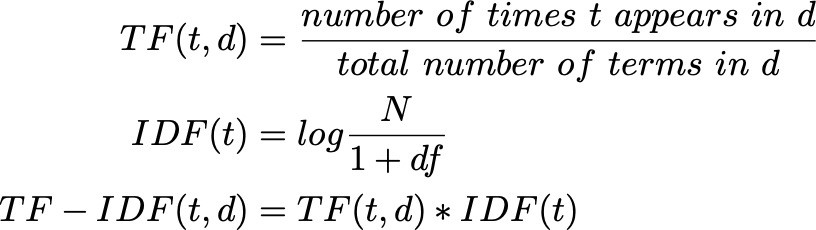

where d refers to a document, N is the total number of documents, df is the number of documents with term t. TF-IDF are word frequency scores that try to highlight words that are more interesting. The scores have the effect of highlighting words that are distinct in a given document.

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer( use_idf=True, max_features=3000)
X_train_transformed = vectorizer.fit_transform(X_train).toarray()
X_test_transformed = vectorizer.transform(X_test).toarray()

In [ ]:
X_train_transformed 

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.09227639, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [ ]:
X_train_transformed1=X_train_transformed.reshape(X_train_transformed.shape[0],X_train_transformed.shape[1],1)
X_test_transformed1=X_test_transformed.reshape(X_test_transformed.shape[0],X_test_transformed.shape[1],1)

Conv Model

In [ ]:
def conv_model():
  model = keras.Sequential([
      # keras.layers.Embedding(vocab_size, dims, weights=[embedding_matrix], input_length=maxlen,trainable=False),
      keras.layers.Conv1D(128, 5, activation='relu'),
      keras.layers.MaxPooling1D(),
      keras.layers.Flatten(),
      keras.layers.Dense(1, activation='sigmoid')

  ])
  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
  return model

In [ ]:
conv_model=conv_model()
conv_model.fit(X_train_transformed1,y_train,epochs=6,batch_size=128,verbose=1,validation_split=0.2)

Epoch 1/6
250/250 [==============================] - 24s 58ms/step - loss: 0.4280 - accuracy: 0.8224 - val_loss: 0.3261 - val_accuracy: 0.8581
Epoch 2/6
250/250 [==============================] - 15s 60ms/step - loss: 0.2959 - accuracy: 0.8736 - val_loss: 0.3062 - val_accuracy: 0.8686
Epoch 3/6
250/250 [==============================] - 14s 56ms/step - loss: 0.2726 - accuracy: 0.8841 - val_loss: 0.2939 - val_accuracy: 0.8742
Epoch 4/6
250/250 [==============================] - 17s 66ms/step - loss: 0.2595 - accuracy: 0.8924 - val_loss: 0.2955 - val_accuracy: 0.8786
Epoch 5/6
250/250 [==============================] - 14s 57ms/step - loss: 0.2527 - accuracy: 0.8941 - val_loss: 0.2974 - val_accuracy: 0.8766
Epoch 6/6
250/250 [==============================] - 15s 61ms/step - loss: 0.2482 - accuracy: 0.8954 - val_loss: 0.2986 - val_accuracy: 0.8759


In [ ]:
score = conv_model.evaluate(X_test_transformed1, y_test, verbose=1) 
print("Test Score:", score[0]) 
print("Test Accuracy:", score[1])

313/313 [==============================] - 4s 13ms/step - loss: 0.3053 - accuracy: 0.8726
Test Score: 0.3053252100944519
Test Accuracy: 0.8726000189781189


LSTM Model

In [ ]:
def lstm_model():
  model = keras.Sequential([
        # keras.layers.Embedding(vocab_size, dims, weights=[embedding_matrix],input_length=maxlen),
        keras.layers.LSTM(128),
        keras.layers.Flatten(),
        keras.layers.Dense(1, activation='sigmoid')
  ])
  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
  return model

In [ ]:
lstm_model=lstm_model()
lstm_model.fit(X_train_transformed1,y_train,epochs=6,batch_size=128,verbose=1,validation_split=0.2)

Epoch 1/6
250/250 [==============================] - 134s 513ms/step - loss: 0.6930 - accuracy: 0.5125 - val_loss: 0.6924 - val_accuracy: 0.5178
Epoch 2/6
250/250 [==============================] - 128s 511ms/step - loss: 0.7394 - accuracy: 0.5131 - val_loss: 0.6935 - val_accuracy: 0.4990
Epoch 3/6
250/250 [==============================] - 129s 516ms/step - loss: 0.6932 - accuracy: 0.5009 - val_loss: 0.6930 - val_accuracy: 0.4997
Epoch 4/6
250/250 [==============================] - 128s 513ms/step - loss: 0.6931 - accuracy: 0.5001 - val_loss: 0.6930 - val_accuracy: 0.5059
Epoch 5/6
250/250 [==============================] - 129s 517ms/step - loss: 0.6931 - accuracy: 0.5042 - val_loss: 0.6931 - val_accuracy: 0.4951
Epoch 6/6
250/250 [==============================] - 129s 515ms/step - loss: 0.6930 - accuracy: 0.5063 - val_loss: 0.6932 - val_accuracy: 0.5064


In [ ]:
score = lstm_model.evaluate(X_test_transformed1, y_test, verbose=1) 
print("Test Score:", score[0]) 
print("Test Accuracy:", score[1])

313/313 [==============================] - 43s 138ms/step - loss: 0.6931 - accuracy: 0.5039
Test Score: 0.6930676102638245
Test Accuracy: 0.5038999915122986


GRU model

In [ ]:
def gru_model():
  model = keras.Sequential([
      # keras.layers.Embedding(vocab_size, dims, weights=[embedding_matrix],input_length=maxlen),
      keras.layers.GRU(128),
      keras.layers.Flatten(),
      keras.layers.Dense(1, activation='sigmoid')
  ])
  
  
  model.compile(loss='binary_crossentropy',optimizer="adam",metrics=['accuracy'])
  return model

In [ ]:
gru_model=gru_model()
gru_model.fit(X_train_transformed1,y_train,epochs=6,batch_size=128,verbose=1,validation_split=0.2)

Epoch 1/6
250/250 [==============================] - 109s 426ms/step - loss: 0.6926 - accuracy: 0.5117 - val_loss: 0.6905 - val_accuracy: 0.5113
Epoch 2/6
250/250 [==============================] - 106s 423ms/step - loss: 0.6910 - accuracy: 0.5154 - val_loss: 0.6909 - val_accuracy: 0.5086
Epoch 3/6
250/250 [==============================] - 106s 423ms/step - loss: 0.6906 - accuracy: 0.5136 - val_loss: 0.6903 - val_accuracy: 0.5065
Epoch 4/6
250/250 [==============================] - 108s 432ms/step - loss: 0.6898 - accuracy: 0.5220 - val_loss: 0.6859 - val_accuracy: 0.5324
Epoch 5/6
250/250 [==============================] - 108s 433ms/step - loss: 0.6890 - accuracy: 0.5266 - val_loss: 0.6890 - val_accuracy: 0.5174
Epoch 6/6
250/250 [==============================] - 108s 432ms/step - loss: 0.6902 - accuracy: 0.5358 - val_loss: 0.6873 - val_accuracy: 0.5361


In [ ]:
score = gru_model.evaluate(X_test_transformed1, y_test, verbose=1) 
print("Test Score:", score[0]) 
print("Test Accuracy:", score[1])

313/313 [==============================] - 54s 173ms/step - loss: 0.6885 - accuracy: 0.5375
Test Score: 0.6885188221931458
Test Accuracy: 0.5375000238418579


# Final Results

|X||Glove||Word2Vec||Fasttext||tf-idf|
|-||-----||--------||--------||------|
|LSTM||0.88||0.865||0.865||0.503|
|GRU||0.88||0.865||0.859||0.537|
|CONV||0.82||0.792||0.819||0.872|

LSTM semble être le meilleur classifieur pour les 3 techniques d'Embedding avec des résultats très proches de GRU ce qui est prévisible vu la similarité des deux architectures.